In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

In [3]:
function ridc_step(f, tspan, y0 , N)
    
 
    K = 2
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[1], t[2]) # Quadrature
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
    return y[1, N+1, K+1]
end

ridc_step (generic function with 1 method)

In [ ]:
# Example 1: y'= -y^3, y(0)=1; T in [0, T]

using Plots

y0=1.0



tspan=[0 7]


f(t, y)=  - y .^3 



# Exact Solution

exact = 1/sqrt(1+2*tspan[2])

p=6 # Parameter for various N values

q=5 # subinterval varying parameter

err2 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err2[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err2[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err2[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p-1
    plot!(nsub, err2[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

In [ ]:
order2=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[i,:]),1)
    order2[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order2[1:end-1], xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

In [ ]:
# Example 1: y'= - y .+ sin.(10*t), y(0)=1; T in [0, T]

using Plots

y0=1.0

lambda= 1

tspan=[0 15]


f(t, y)= - y .+ sin.(10*t)



# Exact Solution

exact = -(1/101)* exp(-tspan[2]) *(-111 +10*exp(tspan[2]) *cos(10*tspan[2])- exp(tspan[2]) *sin(10*tspan[2]))

p=8 # Parameter for various N values

q=6 # subinterval varying parameter

err1 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err1[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err1[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err1[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err1[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err1[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

In [ ]:
order1=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err1[i,:]),1)
    order1[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order1[1:end-1], xaxis=:log, xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

 N=6, p= 4.624345181297388
 N=12, p= 4.788252014494254
 N=24, p= 5.149559965281342
 N=48, p= 5.3100159512849565
 N=96, p= 5.727230680753948


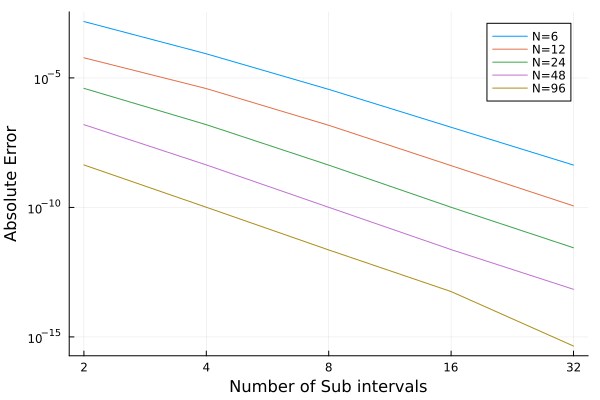

In [107]:
# Example 1: y'= - y .+ sin.(10*t), y(0)=1; T in [0, T]

using Plots

y0=1.0


tspan=[0 1]


f(t, y)= -2*pi .* cos.(t) .* y .^3



# Exact Solution

exact = 1/sqrt(1+4*pi*sin(tspan[2]))

p=5 # Parameter for various N values

q=5 # subinterval varying parameter

err = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

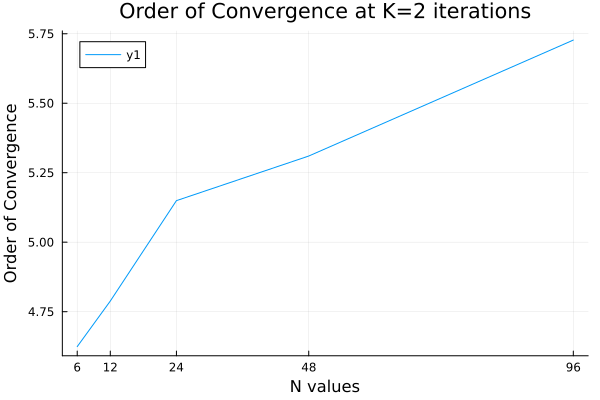

In [108]:
order=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err[i,:]),1)
    order[i]=abs(pdeg[2])
end
plot(nval, order, xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)